In [ ]:
!ls -al /content/drive/MyDrive/lab4

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary

from matplotlib import pyplot as plt
from time import time as Timer
from scipy.io import loadmat
import numpy as np
import math, sys

DATASET_DIR = "/content/drive/MyDrive/AE-4-EEG-Artifact-Removal/BCICIV2a/"
BASE_DIR = "/content/drive/MyDrive/lab4/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch shape: (batch_size, chan (depth), h, w)

In [2]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(16*17, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)
        
        x = x.view(-1, 16*17)
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

In [ ]:
class ShallowConvNet(nn.Module):
    def __init__(self):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (22, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        # self.SquareLayer = square_layer()
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        # self.LogLayer = Log_layer()
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*74, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*74)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
class SCCNet(nn.Module):
    def __init__(self):
        super(SCCNet, self).__init__()
        # bs, 1, channel, sample
        self.conv1 = nn.Conv2d(1, 22, (22, 1))
        self.Bn1 = nn.BatchNorm2d(22)
        # bs, 22, 1, sample
        self.conv2 = nn.Conv2d(22, 20, (1, 12), padding=(0, 6))
        self.Bn2   = nn.BatchNorm2d(20)
        # self.SquareLayer = square_layer()
        self.Drop1 = nn.Dropout(0.5)
        self.AvgPool1 = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.classifier = nn.Linear(840, 4, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bn1(x)
        x = self.conv2(x)
        x = self.Bn2(x)
        x = x ** 2
        x = self.Drop1(x)
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = x.view(-1, 840)
        x = self.classifier(x)

        #x = self.softmax(x)
        return x

In [ ]:
class TSception(nn.Module):
    def conv_block(self, in_chan, out_chan, kernel, step, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan,
                      kernel_size=kernel, stride=step, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool)))

    def __init__(self, num_classes, input_size, sampling_rate, num_T, num_S, hidden, dropout_rate):
        # input_size: 1 x EEG channel x datapoint
        super(TSception, self).__init__()
        self.inception_window = [0.5, 0.25, 0.125]
        self.pool = 8
        # by setting the convolutional kernel being (1,lenght) and the strids being 1 we can use conv2d to
        # achieve the 1d convolution operation
        self.Tception1 = self.conv_block(1, num_T, (1, int(self.inception_window[0] * sampling_rate)), 1, self.pool)
        self.Tception2 = self.conv_block(1, num_T, (1, int(self.inception_window[1] * sampling_rate)), 1, self.pool)
        self.Tception3 = self.conv_block(1, num_T, (1, int(self.inception_window[2] * sampling_rate)), 1, self.pool)

        self.Sception1 = self.conv_block(num_T, num_S, (int(input_size[1]), 1), 1, int(self.pool*0.25))
        self.Sception2 = self.conv_block(num_T, num_S, (int(input_size[1] * 0.5), 1), (int(input_size[1] * 0.5), 1),
                                         int(self.pool*0.25))
        self.fusion_layer = self.conv_block(num_S, num_S, (3, 1), 1, 2)
        self.BN_t = nn.BatchNorm2d(num_T)
        self.BN_s = nn.BatchNorm2d(num_S)
        self.BN_fusion = nn.BatchNorm2d(num_S)

        size = self.get_size(input_size)
        self.fc = nn.Sequential(
            nn.Linear(size[1], hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        y = self.Tception1(x)
        out = y
        y = self.Tception2(x)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(x)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_ = z
        z = self.Sception2(out)
        out_ = torch.cat((out_, z), dim=2)

        out = self.BN_s(out_)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

    def get_size(self, input_size):
        # here we use an array with the shape being
        # (1(mini-batch),1(convolutional channel),EEG channel,time data point)
        # to simulate the input data and get the output size
        data = torch.ones((1, input_size[0], input_size[1], int(input_size[2])))
        y = self.Tception1(data)
        out = y
        y = self.Tception2(data)
        out = torch.cat((out, y), dim=-1)
        y = self.Tception3(data)
        out = torch.cat((out, y), dim=-1)
        out = self.BN_t(out)
        z = self.Sception1(out)
        out_final = z
        z = self.Sception2(out)
        out_final = torch.cat((out_final, z), dim=2)
        out = self.BN_s(out_final)
        out = self.fusion_layer(out)
        out = self.BN_fusion(out)
        out = out.view(out.size()[0], -1)
        return out.size()

In [84]:
""" train, test """
def train(model=None, trainloader=None, validloader=None, epochs=1, lr=0.001):
    doValid = False if validloader == None else True
    history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
    losses = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for ep in range(epochs):
        proc_start = Timer() # timer start
        print(f"Epoch {ep + 1}/{epochs}")
        model.train()
        for x_batch, y_batch in trainloader:
            print("█", end="")
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = model(x_batch)
            loss = losses(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        proc_end = Timer() # timer stop

        loss, acc = evaluate(model, trainloader, dumpstr=False)
        val_loss, val_acc = evaluate(model, validloader, dumpstr=False) if doValid else (0, 0)
        history["loss"] = np.append(history["loss"], loss)
        history["acc"] = np.append(history["acc"], acc)
        history["val_loss"] = np.append(history["val_loss"], val_loss)
        history["val_acc"] = np.append(history["val_acc"], val_acc)
        print(" {:.4f}s - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}".format(
            proc_end-proc_start, history["loss"][-1], history["acc"][-1], history["val_loss"][-1], history["val_acc"][-1])
        )
    return history
def evaluate(model, dataloader, dumpstr=True):
    losses = nn.CrossEntropyLoss()
    total, acc = 0, 0
    model.eval()
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
        pred = model(x_batch)
        loss = losses(pred, y_batch).item()
        total += y_batch.shape[0]
        acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()
    acc /= total
    if dumpstr:
        print(f"Accuracy: {acc:.4f}\tLoss: {loss:.4f}")
    return (loss, acc)

In [4]:
train_raw = loadmat(DATASET_DIR + "BCIC_S01_T.mat")
test_raw = loadmat(DATASET_DIR + "BCIC_S01_E.mat")
trX, trY, teX, teY = train_raw["x_train"], train_raw["y_train"], test_raw["x_test"], test_raw["y_test"]

In [5]:
x_train = torch.from_numpy(np.expand_dims(trX, axis=1))
y_train = torch.from_numpy(np.reshape(trY, (trY.size, ))).long()
x_test = torch.from_numpy(np.expand_dims(teX, axis=1))
y_test = torch.from_numpy(np.reshape(teY, (teY.size, ))).long()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
trainset, testset = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

""" create dataloader """
bs = 32 # batch_size
trainloader = DataLoader(dataset=trainset, batch_size=bs, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=bs, shuffle=True)

torch.Size([288, 1, 22, 562]) torch.Size([288])
torch.Size([288, 1, 22, 562]) torch.Size([288])


In [86]:
eegnet = EEGNet().to(device)

history = train(model=eegnet, trainloader=trainloader, validloader=testloader, epochs=100, lr=0.001)
#history = train(model=eegnet, trainloader=trainloader, epochs=100, lr=0.001)

Epoch 1/100
█████████ 0.0873s - loss: 1.3791 - acc: 0.2604 - val_loss: 1.3891 - val_acc: 0.2431
Epoch 2/100
█████████ 0.0845s - loss: 1.3786 - acc: 0.3229 - val_loss: 1.3819 - val_acc: 0.2847
Epoch 3/100
█████████ 0.0750s - loss: 1.3573 - acc: 0.4097 - val_loss: 1.3755 - val_acc: 0.3090
Epoch 4/100
█████████ 0.0979s - loss: 1.3669 - acc: 0.4444 - val_loss: 1.3629 - val_acc: 0.3576
Epoch 5/100
█████████ 0.0815s - loss: 1.3399 - acc: 0.4826 - val_loss: 1.3659 - val_acc: 0.3889
Epoch 6/100
█████████ 0.0840s - loss: 1.2911 - acc: 0.5382 - val_loss: 1.3411 - val_acc: 0.4618
Epoch 7/100
█████████ 0.0770s - loss: 1.3070 - acc: 0.5208 - val_loss: 1.3110 - val_acc: 0.4722
Epoch 8/100
█████████ 0.0876s - loss: 1.1963 - acc: 0.5104 - val_loss: 1.2000 - val_acc: 0.4444
Epoch 9/100
█████████ 0.0760s - loss: 1.1880 - acc: 0.5139 - val_loss: 1.1727 - val_acc: 0.4340
Epoch 10/100
█████████ 0.0843s - loss: 1.0549 - acc: 0.5382 - val_loss: 1.1418 - val_acc: 0.4722
Epoch 11/100
█████████ 0.0821s - loss: 

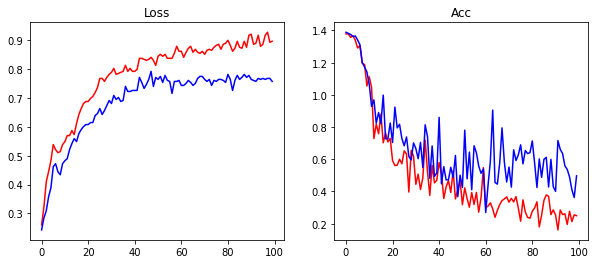

In [87]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history["acc"], color="red")
plt.plot(history["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Acc")
plt.plot(history["loss"], color="red")
plt.plot(history["val_loss"], color="blue")
plt.show()

ref

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SCCNet().to(device)
summary(model, (1, 22, 562))

In [16]:
trX = torch.Tensor(train_raw["x_train"]).unsqueeze(1)
trY = torch.Tensor(train_raw["y_train"]).view(-1).long()
testX = torch.Tensor(test_raw["x_test"]).unsqueeze(1)
testY = torch.Tensor(test_raw["y_test"]).view(-1).long()

print(trX.shape, trY.shape)
print(testX.shape, testY.shape)
cmp = Tensor().numpy() == np.array()
cmp.all()

True